In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4627 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [5]:
n_classes = len(class_names)
n_classes

5

In [6]:
len(dataset)

145

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 3 1 3 1 1 3 0 1 3 3 3 1 2 1 2 1 1 0 2 1 1 1 2 0 2 3 3 0 3 2 0]


In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[163. 151. 151.]
  [153. 141. 141.]
  [190. 178. 178.]
  ...
  [168. 154. 153.]
  [170. 156. 155.]
  [192. 178. 177.]]

 [[187. 175. 175.]
  [162. 150. 150.]
  [198. 186. 186.]
  ...
  [169. 155. 154.]
  [160. 146. 145.]
  [194. 180. 179.]]

 [[185. 173. 173.]
  [168. 156. 156.]
  [168. 156. 156.]
  ...
  [192. 178. 177.]
  [173. 159. 158.]
  [172. 158. 157.]]

 ...

 [[161. 146. 151.]
  [162. 147. 152.]
  [164. 149. 154.]
  ...
  [169. 155. 154.]
  [171. 157. 156.]
  [173. 159. 158.]]

 [[167. 152. 157.]
  [169. 154. 159.]
  [171. 156. 161.]
  ...
  [166. 152. 151.]
  [172. 158. 157.]
  [176. 162. 161.]]

 [[171. 156. 161.]
  [172. 157. 162.]
  [171. 156. 161.]
  ...
  [173. 159. 158.]
  [182. 168. 167.]
  [189. 175. 174.]]], shape=(256, 256, 3), dtype=float32)


In [9]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


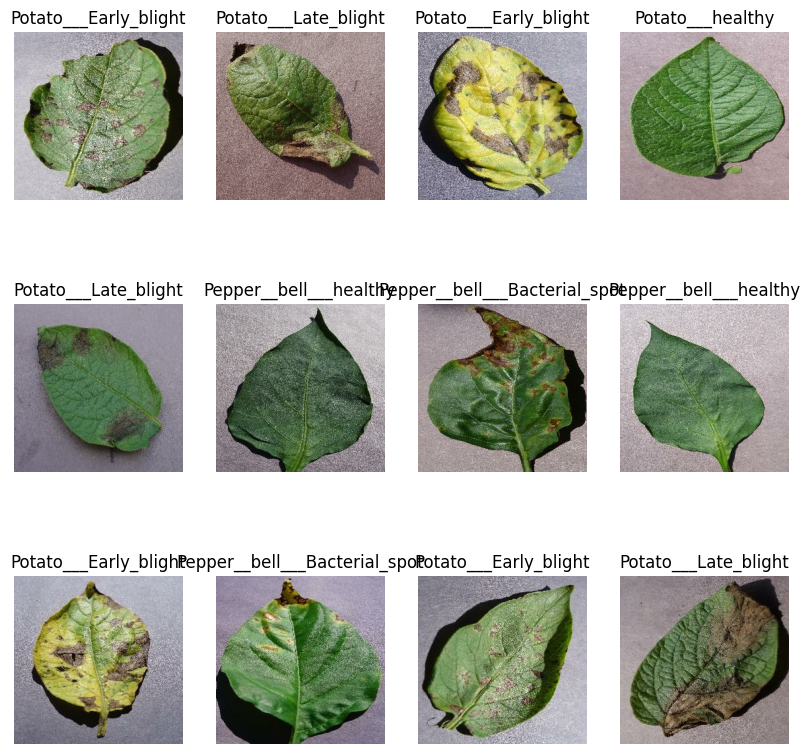

In [10]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

80% data ==> traning ||||
20% data ==> 10% validation, 10% test

In [11]:
train_size = 0.8
len(dataset) * train_size

116.0

In [12]:
train_ds = dataset.take(54)
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54)
len(test_ds)

91

In [14]:
val_size = 0.1
len(dataset) * val_size

14.5

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

85

Making function for easy partitioning

In [16]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

116

In [19]:
len(val_ds)

14

In [20]:
len(test_ds)

15

PREPROCESSING

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
 data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape= (input_shape)),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

model.build(input_shape = input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (32, 516128)              0         
                                                                 
 dense (Dense)               (32, 64)                  33032256  
                                                      

In [26]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics =['accuracy']
)

In [27]:
history = model.fit(
    train_ds, 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1, 
    validation_data = val_ds
)

Epoch 1/50
116/116 [==============================] - 214s 2s/step - loss: 5.7680 - accuracy: 0.4920 - val_loss: 0.8450 - val_accuracy: 0.7080
Epoch 2/50
116/116 [==============================] - 153s 1s/step - loss: 0.7149 - accuracy: 0.7429 - val_loss: 0.6148 - val_accuracy: 0.7816
Epoch 3/50
116/116 [==============================] - 140s 1s/step - loss: 0.5000 - accuracy: 0.8278 - val_loss: 0.5903 - val_accuracy: 0.7563
Epoch 4/50
116/116 [==============================] - 142s 1s/step - loss: 0.4039 - accuracy: 0.8556 - val_loss: 0.5071 - val_accuracy: 0.7954
Epoch 5/50
116/116 [==============================] - 141s 1s/step - loss: 0.3323 - accuracy: 0.8786 - val_loss: 0.5090 - val_accuracy: 0.8299
Epoch 6/50
116/116 [==============================] - 136s 1s/step - loss: 0.3333 - accuracy: 0.8821 - val_loss: 0.5707 - val_accuracy: 0.8046
Epoch 7/50
116/116 [==============================] - 136s 1s/step - loss: 0.3413 - accuracy: 0.8786 - val_loss: 0.3447 - val_accuracy: 0.8598

In [28]:
score = model.evaluate(test_ds)

15/15 [==============================] - 26s 327ms/step - loss: 0.1707 - accuracy: 0.9354


In [29]:
score

[0.17068301141262054, 0.9354166388511658]

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 116}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy'] 

loss = history.history['loss']
val_loss = history.history['val_loss']

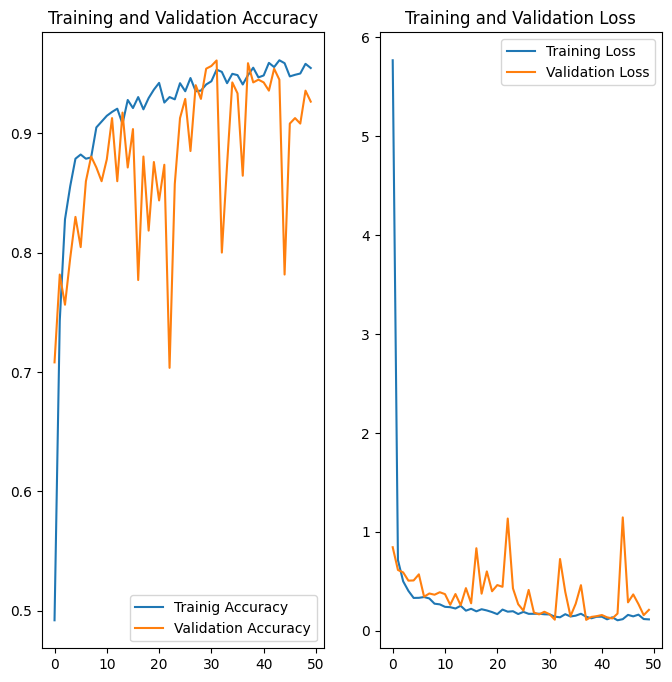

In [33]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Trainig Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

first image tp predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 687ms/step
Predicted label :  Pepper__bell___Bacterial_spot


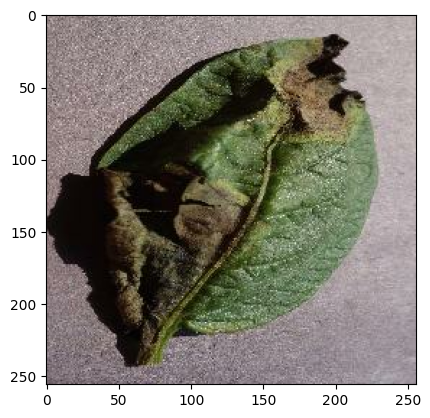

In [34]:
import numpy as np
for images_batch, label_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("first image tp predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print('Predicted label : ', class_names[np.argmax(batch_prediction[0])])
    

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 67ms/step


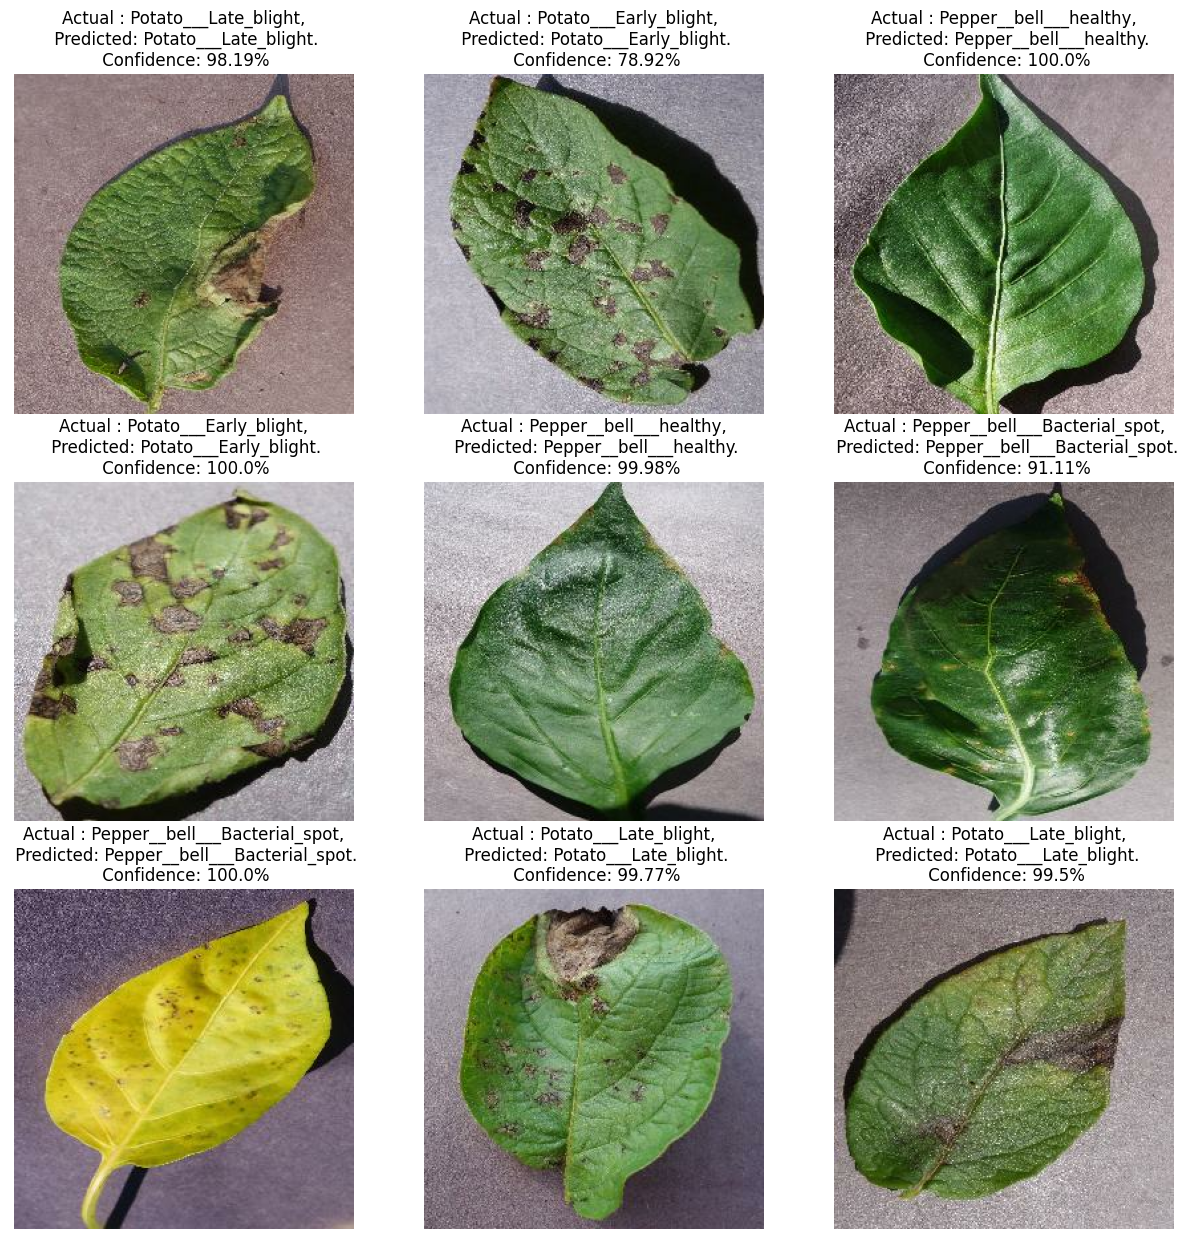

In [39]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
 
        plt.title(f"Actual : {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [63]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}") 

INFO:tensorflow:Assets written to: ../models/2\assets


INFO:tensorflow:Assets written to: ../models/2\assets
